In [67]:
import pickle
import pandas as pd
import os
import json
import glob

import numpy as np
from optimizers.utils import Model, Architecture

from nasbench_analysis.search_spaces.search_space_1 import SearchSpace1
from nasbench_analysis.search_spaces.search_space_2 import SearchSpace2
from nasbench_analysis.search_spaces.search_space_3 import SearchSpace3

from nasbench_analysis.utils import INPUT, OUTPUT, CONV1X1, NasbenchWrapper, upscale_to_nasbench_format, natural_keys

path = "experiments/discrete_optimizers/"
ssp = 1
algo = "RS"
n_runs = 500

search_space = eval('SearchSpace{}()'.format(ssp))
y_star_valid, y_star_test, inc_config = (search_space.valid_min_error,
                                         search_space.test_min_error, None)

class DotAccess():
    def __init__(self, valid, info, test):
        self.valid = valid
        self.info = info
        self.test = test
        
def process_and_save(all_runs):
    global y_star_valid, y_star_test
    valid_incumbents = []
    runtimes = []
    test_incumbents = []
    inc = np.inf
    test_regret = 1

    for k in range(len(all_runs)):
        print('Iteration {:<3}/{:<3}'.format(k+1, len(all_runs)), end="\r", flush=True)
        regret = all_runs[k].valid - y_star_valid
        # Update test regret only when incumbent changed by validation regret
        if regret <= inc:
            inc = regret
            test_regret = all_runs[k].test - y_star_test
        valid_incumbents.append(inc)
        test_incumbents.append(test_regret)
        runtimes.append(all_runs[k].info)
    runtimes = np.cumsum(runtimes).tolist()
    return valid_incumbents, runtimes, test_incumbents


# with open(os.path.join(path, 'config.json')) as fp:
#     config = json.load(fp)

re_archs = glob.glob(os.path.join(path, 'algo_{}_0_ssp_{}_seed_*.obj'.format(algo, ssp)))

# Sort them by date
re_archs.sort(key=natural_keys)

for i in range(n_runs):
    res = pickle.load(open(re_archs[i], 'rb'))
    all_runs = []
    for j in range(len(res)):
        all_runs.append(DotAccess(valid = 1 - res[j].validation_accuracy,
                                  info  = res[j].training_time,
                                  test  = 1 - res[j].test_accuracy))
        
    valid_incumbents, runtimes, test_incumbents = process_and_save(all_runs)
    directory  = os.path.join(path, '{}/{}/'.format(algo, ssp))
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(path, '{}/{}/'
              'run_{}.json'.format(algo, ssp, i)), 'w') as f:
        json.dump({'runtime': runtimes, 'regret_validation': valid_incumbents,
                   'regret_test': test_incumbents}, f)

0. Plotting for RS
500 500
1. Plotting for RE
500 500
2. Plotting for EE
500 500


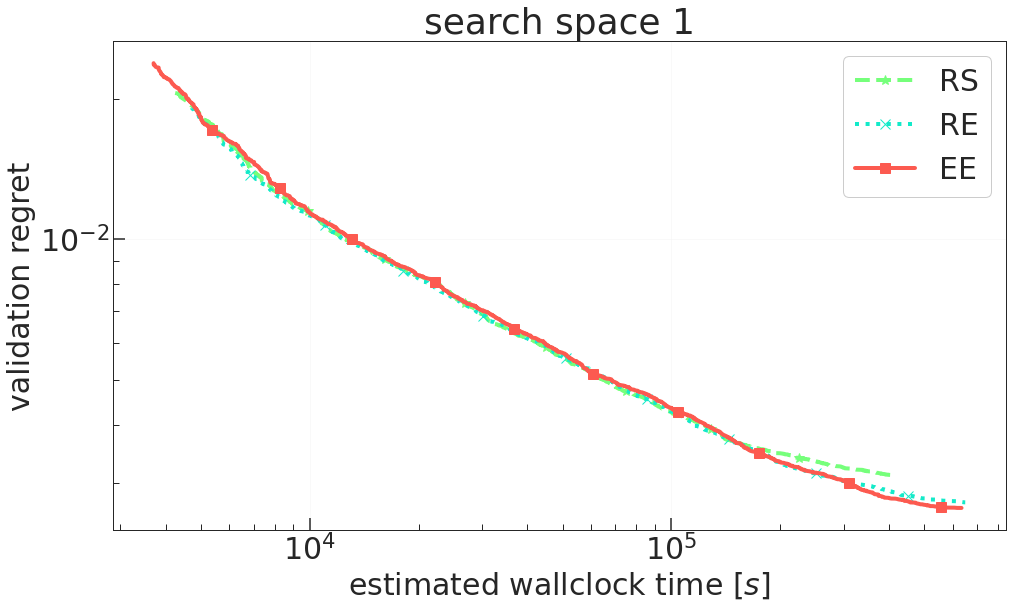

In [106]:
'''Script to plot regret curves for multiple runs on the benchmarks
'''

import os
import json
import sys
import pickle
import argparse
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
# seaborn.set_style("ticks")

# from matplotlib import rcParams
# rcParams["font.size"] = "30"
# rcParams['text.usetex'] = False
# rcParams['figure.figsize'] = (16.0, 9.0)
# rcParams['figure.frameon'] = True
# rcParams['figure.edgecolor'] = 'k'
# rcParams['grid.color'] = 'k'
# rcParams['grid.linestyle'] = ':'
# rcParams['grid.linewidth'] = 0.5
# rcParams['axes.linewidth'] = 1
# rcParams['axes.edgecolor'] = 'k'
# rcParams['axes.grid.which'] = 'both'
# rcParams['legend.frameon'] = 'True'
# rcParams['legend.framealpha'] = 1

# rcParams['ytick.major.size'] = 12
# rcParams['ytick.major.width'] = 1.5
# rcParams['ytick.minor.size'] = 6
# rcParams['ytick.minor.width'] = 1
# rcParams['xtick.major.size'] = 12
# rcParams['xtick.major.width'] = 1.5
# rcParams['xtick.minor.size'] = 6
# rcParams['xtick.minor.width'] = 1

marker=['*', 'x', 's', 's', 's', 'h', '*', 'v', '<', ">"]
linestyles = ['--', ':', '-',]

def fill_trajectory(performance_list, time_list, replace_nan=np.NaN):
    frame_dict = collections.OrderedDict()
    counter = np.arange(0, len(performance_list))
    for p, t, c in zip(performance_list, time_list, counter):
        if len(p) != len(t):
            raise ValueError("(%d) Array length mismatch: %d != %d" %
                             (c, len(p), len(t)))
        frame_dict[str(c)] = pd.Series(data=p, index=t)

    # creates a dataframe where the rows are indexed based on time
    # fills with NA for missing values for the respective timesteps
    merged = pd.DataFrame(frame_dict)
    # ffill() acts like a fillna() wherein a forward fill happens
    # only remaining NAs for in the beginning until a value is recorded
    merged = merged.ffill()

    performance = merged.to_numpy() #get_values()  # converts to a 2D numpy array
    time_ = merged.index.values        # retrieves the timestamps

    performance[np.isnan(performance)] = replace_nan

    if not np.isfinite(performance).all():
        raise ValueError("\nCould not merge lists, because \n"
                         "\t(a) one list is empty?\n"
                         "\t(b) the lists do not start with the same times and"
                         " replace_nan is not set?\n"
                         "\t(c) any other reason.")

    return performance, time_


# parser = argparse.ArgumentParser()

# parser.add_argument('--bench', default='1shot1', type=str, nargs='?',
#                     choices=['101', '1shot1', '201'], help='select benchmark')
# parser.add_argument('--ssp', default=1, type=int, nargs='?')
# parser.add_argument('--path', default='experiments/discrete_optimizers', type=str, nargs='?',
#                     help='path to encodings or jsons for each algorithm')
# parser.add_argument('--n_runs', default=500, type=int, nargs='?',
#                     help='number of runs to plot data for')
# parser.add_argument('--output_path', default="", type=str, nargs='?',
#                     help='specifies the path where the plot will be saved')
# parser.add_argument('--type', default="wallclock", type=str, choices=["wallclock", "fevals"],
#                     help='to plot for wallclock times or # function evaluations')
# parser.add_argument('--name', default="comparison", type=str,
#                     help='file name for the PNG plot to be saved')
# parser.add_argument('--title', default="benchmark", type=str,
#                     help='title name for the plot')
# parser.add_argument('--limit', default=1e7, type=float, help='wallclock limit')
# parser.add_argument('--regret', default='validation', type=str, choices=['validation', 'test'],
#                     help='type of regret')

# args = parser.parse_args()
path = 'experiments/discrete_optimizers'
n_runs = 500
plot_type = 'wallclock'
plot_name = 'comparison'
regret_type = 'validation'
benchmark = '1shot1'
ssp = '1'
limit=1e7
title = 'search space 1'
output_path = ''

if benchmark == '1shot1' and ssp is None:
    print("Specify \'--ssp\' from {1, 2, 3} for choosing the search space for NASBench-1shot1.")
    sys.exit()

if benchmark == '101':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$")]
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
elif benchmark == '201':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$"),
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
else:
    methods = [
               ("RS", "RS"),
               ("RE", "RE"),
               #("BOHB", "BOHB"),
               #("HB", "HB"),
               #("TPE", "TPE"),
               ("EE", "EE")]
               #("DE_pop20", "DE")]
               # ("DE_pop10", "DE $pop=10$"),
               # ("DE_pop20", "DE $pop=20$"),
               # ("DE_pop30", "DE $pop=30$"),
               # ("DE_pop40", "DE $pop=40$"),
               # ("DE_pop50", "DE $pop=50$"),
               # ("DE_pop60", "DE $pop=60$"),
               # ("DE_pop70", "DE $pop=70$"),
               # ("DE_pop80", "DE $pop=80$"),
               # ("DE_pop90", "DE $pop=90$"),
               # ("DE_pop100", "DE $pop=100$")]


# plot limits
min_time = np.inf
max_time = 0
min_regret = 1
max_regret = 0

# plot setup
colors = ['xkcd:lightgreen', 'xkcd:aqua', 'xkcd:coral']
plt.clf()

# looping and plotting for all methods
for index, (m, label) in enumerate(methods):
    regret = []
    runtimes = []
    for k, i in enumerate(np.arange(n_runs)):
        try:
            if benchmark in ['101', '201']:
                res = json.load(open(os.path.join(path, m, "run_%d.json" % i)))
            else:
                res = json.load(open(os.path.join(path, m, str(ssp), "run_%d.json" % i)))
            no_runs_found = False
        except Exception as e:
            print(m, i, e)
            no_runs_found = True
            continue
        regret_key =  "regret_validation" if regret_type == 'validation' else "regret_test"
        runtime_key = "runtime"
        _, idx = np.unique(res[regret_key], return_index=True)
        idx.sort()
        regret.append(np.array(res[regret_key])[idx])
        runtimes.append(np.array(res[runtime_key])[idx])

    if not no_runs_found:
        # finds the latest time where the first measurement was made across runs
        t = np.max([runtimes[i][0] for i in range(len(runtimes))])
        min_time = min(min_time, t)
        te, time = fill_trajectory(regret, runtimes, replace_nan=1)

        idx = time.tolist().index(t)
        te = te[idx:, :]
        time = time[idx:]

        # Clips off all measurements after 10^7s
        idx = np.where(time < limit)[0]

        print("{}. Plotting for {}".format(index, m))
        print(len(regret), len(runtimes))
        # The mean plot
        plt.plot(time[idx], np.mean(te, axis=1)[idx], color=colors[index],
                 linewidth=4, label=label, linestyle=linestyles[index % len(linestyles)],
                 marker=marker[index % len(marker)], markevery=(0.1,0.1), markersize=10)
#         # The error band
#         plt.fill_between(time[idx],
#                          np.mean(te, axis=1)[idx] + 2 * stats.sem(te[idx], axis=1),
#                          np.mean(te[idx], axis=1)[idx] - 2 * stats.sem(te[idx], axis=1),
#                          color="C%d" % index, alpha=0.2)

        # Stats to dynamically impose limits on the axes of the plots
        max_time = max(max_time, time[idx][-1])
        min_regret = min(min_regret, np.mean(te, axis=1)[idx][-1])
        max_regret = max(max_regret, np.mean(te, axis=1)[idx][0])

plt.xscale("log")
plt.yscale("log")
plt.tick_params(which='both', direction="in")
plt.legend(loc='lower left', framealpha=1, prop={'size': 25, 'weight': 'bold'})
plt.title(title)
if plot_type == "wallclock":
    plt.xlabel("estimated wallclock time $[s]$")
elif plot_type == "fevals":
    plt.xlabel("number of function evaluations")
plt.ylabel("{} regret".format(regret_type))
# plt.xlim(max(min_time/10, 1e0), min(max_time*10, 1e7))
# plt.ylim(min_regret, max_regret)

bottom, top = plt.ylim() 
plt.ylim((bottom,top))

plt.legend()

# plt.grid(which='both', alpha=0.5, linewidth=0.5)
plt.grid(b=True, which='major', color='#F4F4F4', linestyle='-')
# print(os.path.join(output_path, '{}.png'.format(plot_name)))
plt.savefig(os.path.join(output_path, '{}.png'.format(plot_name)), format='png', bbox_inches='tight', dpi=300)

0. Plotting for RS
500 500
1. Plotting for RE
500 500
2. Plotting for EE
500 500


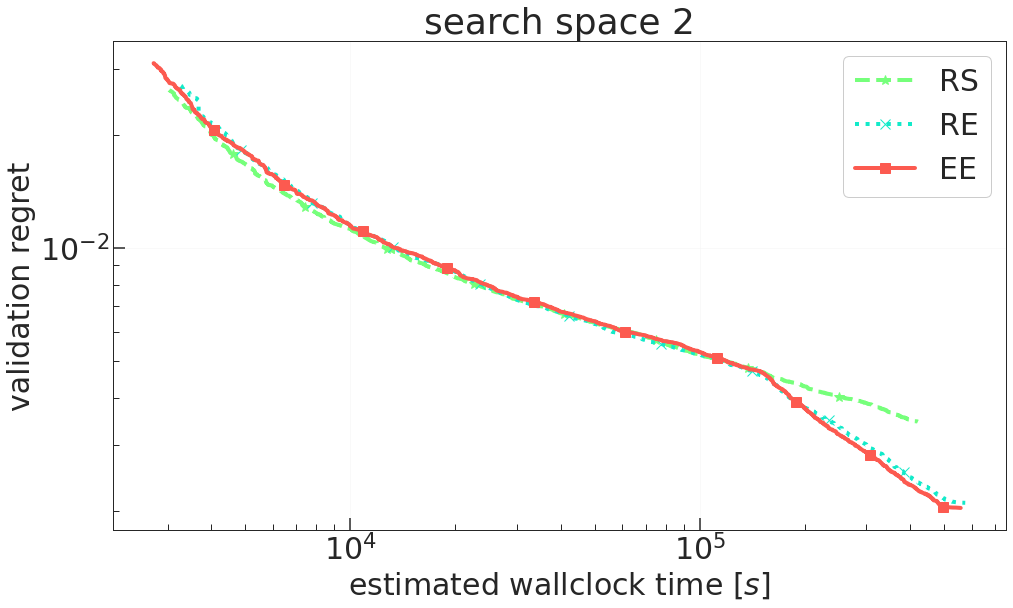

In [108]:
'''Script to plot regret curves for multiple runs on the benchmarks
'''

import os
import json
import sys
import pickle
import argparse
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
# seaborn.set_style("ticks")

# from matplotlib import rcParams
# rcParams["font.size"] = "30"
# rcParams['text.usetex'] = False
# rcParams['figure.figsize'] = (16.0, 9.0)
# rcParams['figure.frameon'] = True
# rcParams['figure.edgecolor'] = 'k'
# rcParams['grid.color'] = 'k'
# rcParams['grid.linestyle'] = ':'
# rcParams['grid.linewidth'] = 0.5
# rcParams['axes.linewidth'] = 1
# rcParams['axes.edgecolor'] = 'k'
# rcParams['axes.grid.which'] = 'both'
# rcParams['legend.frameon'] = 'True'
# rcParams['legend.framealpha'] = 1

# rcParams['ytick.major.size'] = 12
# rcParams['ytick.major.width'] = 1.5
# rcParams['ytick.minor.size'] = 6
# rcParams['ytick.minor.width'] = 1
# rcParams['xtick.major.size'] = 12
# rcParams['xtick.major.width'] = 1.5
# rcParams['xtick.minor.size'] = 6
# rcParams['xtick.minor.width'] = 1

marker=['*', 'x', 's', 's', 's', 'h', '*', 'v', '<', ">"]
linestyles = ['--', ':', '-',]

def fill_trajectory(performance_list, time_list, replace_nan=np.NaN):
    frame_dict = collections.OrderedDict()
    counter = np.arange(0, len(performance_list))
    for p, t, c in zip(performance_list, time_list, counter):
        if len(p) != len(t):
            raise ValueError("(%d) Array length mismatch: %d != %d" %
                             (c, len(p), len(t)))
        frame_dict[str(c)] = pd.Series(data=p, index=t)

    # creates a dataframe where the rows are indexed based on time
    # fills with NA for missing values for the respective timesteps
    merged = pd.DataFrame(frame_dict)
    # ffill() acts like a fillna() wherein a forward fill happens
    # only remaining NAs for in the beginning until a value is recorded
    merged = merged.ffill()

    performance = merged.to_numpy() #get_values()  # converts to a 2D numpy array
    time_ = merged.index.values        # retrieves the timestamps

    performance[np.isnan(performance)] = replace_nan

    if not np.isfinite(performance).all():
        raise ValueError("\nCould not merge lists, because \n"
                         "\t(a) one list is empty?\n"
                         "\t(b) the lists do not start with the same times and"
                         " replace_nan is not set?\n"
                         "\t(c) any other reason.")

    return performance, time_


# parser = argparse.ArgumentParser()

# parser.add_argument('--bench', default='1shot1', type=str, nargs='?',
#                     choices=['101', '1shot1', '201'], help='select benchmark')
# parser.add_argument('--ssp', default=1, type=int, nargs='?')
# parser.add_argument('--path', default='experiments/discrete_optimizers', type=str, nargs='?',
#                     help='path to encodings or jsons for each algorithm')
# parser.add_argument('--n_runs', default=500, type=int, nargs='?',
#                     help='number of runs to plot data for')
# parser.add_argument('--output_path', default="", type=str, nargs='?',
#                     help='specifies the path where the plot will be saved')
# parser.add_argument('--type', default="wallclock", type=str, choices=["wallclock", "fevals"],
#                     help='to plot for wallclock times or # function evaluations')
# parser.add_argument('--name', default="comparison", type=str,
#                     help='file name for the PNG plot to be saved')
# parser.add_argument('--title', default="benchmark", type=str,
#                     help='title name for the plot')
# parser.add_argument('--limit', default=1e7, type=float, help='wallclock limit')
# parser.add_argument('--regret', default='validation', type=str, choices=['validation', 'test'],
#                     help='type of regret')

# args = parser.parse_args()
path = 'experiments/discrete_optimizers'
n_runs = 500
plot_type = 'wallclock'
plot_name = 'comparison'
regret_type = 'validation'
benchmark = '1shot1'
ssp = '2'
limit=1e7
title = 'search space 2'
output_path = ''

if benchmark == '1shot1' and ssp is None:
    print("Specify \'--ssp\' from {1, 2, 3} for choosing the search space for NASBench-1shot1.")
    sys.exit()

if benchmark == '101':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$")]
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
elif benchmark == '201':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$"),
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
else:
    methods = [
               ("RS", "RS"),
               ("RE", "RE"),
               #("BOHB", "BOHB"),
               #("HB", "HB"),
               #("TPE", "TPE"),
               ("EE", "EE")]
               #("DE_pop20", "DE")]
               # ("DE_pop10", "DE $pop=10$"),
               # ("DE_pop20", "DE $pop=20$"),
               # ("DE_pop30", "DE $pop=30$"),
               # ("DE_pop40", "DE $pop=40$"),
               # ("DE_pop50", "DE $pop=50$"),
               # ("DE_pop60", "DE $pop=60$"),
               # ("DE_pop70", "DE $pop=70$"),
               # ("DE_pop80", "DE $pop=80$"),
               # ("DE_pop90", "DE $pop=90$"),
               # ("DE_pop100", "DE $pop=100$")]


# plot limits
min_time = np.inf
max_time = 0
min_regret = 1
max_regret = 0

# plot setup
colors = ['xkcd:lightgreen', 'xkcd:aqua', 'xkcd:coral']
plt.clf()

# looping and plotting for all methods
for index, (m, label) in enumerate(methods):
    regret = []
    runtimes = []
    for k, i in enumerate(np.arange(n_runs)):
        try:
            if benchmark in ['101', '201']:
                res = json.load(open(os.path.join(path, m, "run_%d.json" % i)))
            else:
                res = json.load(open(os.path.join(path, m, str(ssp), "run_%d.json" % i)))
            no_runs_found = False
        except Exception as e:
            print(m, i, e)
            no_runs_found = True
            continue
        regret_key =  "regret_validation" if regret_type == 'validation' else "regret_test"
        runtime_key = "runtime"
        _, idx = np.unique(res[regret_key], return_index=True)
        idx.sort()
        regret.append(np.array(res[regret_key])[idx])
        runtimes.append(np.array(res[runtime_key])[idx])

    if not no_runs_found:
        # finds the latest time where the first measurement was made across runs
        t = np.max([runtimes[i][0] for i in range(len(runtimes))])
        min_time = min(min_time, t)
        te, time = fill_trajectory(regret, runtimes, replace_nan=1)

        idx = time.tolist().index(t)
        te = te[idx:, :]
        time = time[idx:]

        # Clips off all measurements after 10^7s
        idx = np.where(time < limit)[0]

        print("{}. Plotting for {}".format(index, m))
        print(len(regret), len(runtimes))
        # The mean plot
        plt.plot(time[idx], np.mean(te, axis=1)[idx], color=colors[index],
                 linewidth=4, label=label, linestyle=linestyles[index % len(linestyles)],
                 marker=marker[index % len(marker)], markevery=(0.1,0.1), markersize=10)
#         # The error band
#         plt.fill_between(time[idx],
#                          np.mean(te, axis=1)[idx] + 2 * stats.sem(te[idx], axis=1),
#                          np.mean(te[idx], axis=1)[idx] - 2 * stats.sem(te[idx], axis=1),
#                          color="C%d" % index, alpha=0.2)

        # Stats to dynamically impose limits on the axes of the plots
        max_time = max(max_time, time[idx][-1])
        min_regret = min(min_regret, np.mean(te, axis=1)[idx][-1])
        max_regret = max(max_regret, np.mean(te, axis=1)[idx][0])

plt.xscale("log")
plt.yscale("log")
plt.tick_params(which='both', direction="in")
plt.legend(loc='lower left', framealpha=1, prop={'size': 25, 'weight': 'bold'})
plt.title(title)
if plot_type == "wallclock":
    plt.xlabel("estimated wallclock time $[s]$")
elif plot_type == "fevals":
    plt.xlabel("number of function evaluations")
plt.ylabel("{} regret".format(regret_type))
# plt.xlim(max(min_time/10, 1e0), min(max_time*10, 1e7))
# plt.ylim(min_regret, max_regret)

bottom, top = plt.ylim() 
plt.ylim((bottom,top))

plt.legend()

# plt.grid(which='both', alpha=0.5, linewidth=0.5)
plt.grid(b=True, which='major', color='#F4F4F4', linestyle='-')
# print(os.path.join(output_path, '{}.png'.format(plot_name)))
plt.savefig(os.path.join(output_path, '{}.png'.format(plot_name)), format='png', bbox_inches='tight', dpi=300)

0. Plotting for RS
500 500
1. Plotting for RE
500 500
2. Plotting for EE
500 500


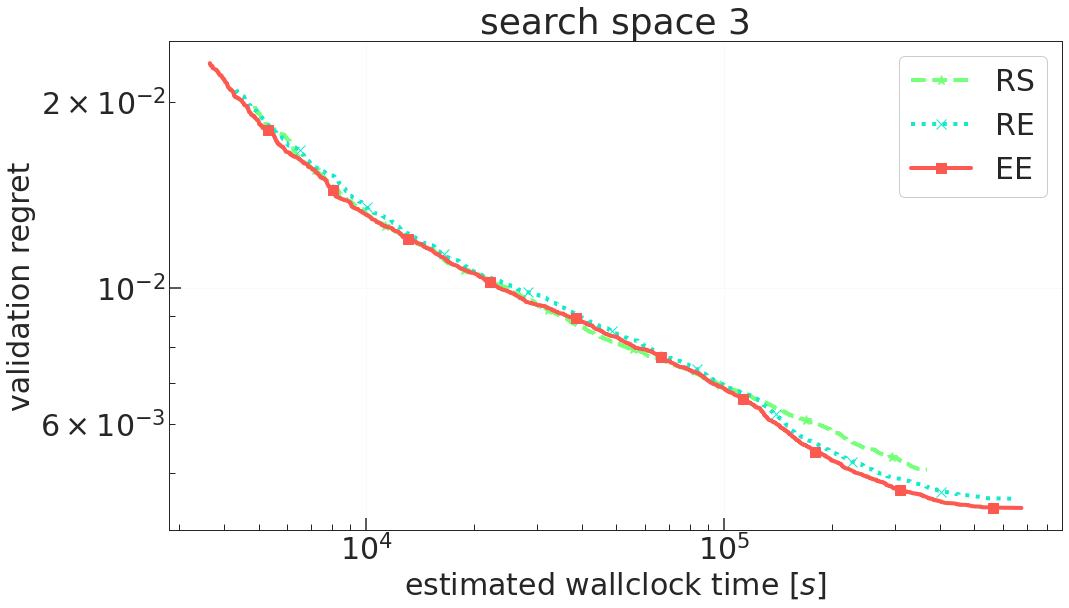

In [109]:
'''Script to plot regret curves for multiple runs on the benchmarks
'''

import os
import json
import sys
import pickle
import argparse
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
# seaborn.set_style("ticks")

# from matplotlib import rcParams
# rcParams["font.size"] = "30"
# rcParams['text.usetex'] = False
# rcParams['figure.figsize'] = (16.0, 9.0)
# rcParams['figure.frameon'] = True
# rcParams['figure.edgecolor'] = 'k'
# rcParams['grid.color'] = 'k'
# rcParams['grid.linestyle'] = ':'
# rcParams['grid.linewidth'] = 0.5
# rcParams['axes.linewidth'] = 1
# rcParams['axes.edgecolor'] = 'k'
# rcParams['axes.grid.which'] = 'both'
# rcParams['legend.frameon'] = 'True'
# rcParams['legend.framealpha'] = 1

# rcParams['ytick.major.size'] = 12
# rcParams['ytick.major.width'] = 1.5
# rcParams['ytick.minor.size'] = 6
# rcParams['ytick.minor.width'] = 1
# rcParams['xtick.major.size'] = 12
# rcParams['xtick.major.width'] = 1.5
# rcParams['xtick.minor.size'] = 6
# rcParams['xtick.minor.width'] = 1

marker=['*', 'x', 's', 's', 's', 'h', '*', 'v', '<', ">"]
linestyles = ['--', ':', '-',]

def fill_trajectory(performance_list, time_list, replace_nan=np.NaN):
    frame_dict = collections.OrderedDict()
    counter = np.arange(0, len(performance_list))
    for p, t, c in zip(performance_list, time_list, counter):
        if len(p) != len(t):
            raise ValueError("(%d) Array length mismatch: %d != %d" %
                             (c, len(p), len(t)))
        frame_dict[str(c)] = pd.Series(data=p, index=t)

    # creates a dataframe where the rows are indexed based on time
    # fills with NA for missing values for the respective timesteps
    merged = pd.DataFrame(frame_dict)
    # ffill() acts like a fillna() wherein a forward fill happens
    # only remaining NAs for in the beginning until a value is recorded
    merged = merged.ffill()

    performance = merged.to_numpy() #get_values()  # converts to a 2D numpy array
    time_ = merged.index.values        # retrieves the timestamps

    performance[np.isnan(performance)] = replace_nan

    if not np.isfinite(performance).all():
        raise ValueError("\nCould not merge lists, because \n"
                         "\t(a) one list is empty?\n"
                         "\t(b) the lists do not start with the same times and"
                         " replace_nan is not set?\n"
                         "\t(c) any other reason.")

    return performance, time_


# parser = argparse.ArgumentParser()

# parser.add_argument('--bench', default='1shot1', type=str, nargs='?',
#                     choices=['101', '1shot1', '201'], help='select benchmark')
# parser.add_argument('--ssp', default=1, type=int, nargs='?')
# parser.add_argument('--path', default='experiments/discrete_optimizers', type=str, nargs='?',
#                     help='path to encodings or jsons for each algorithm')
# parser.add_argument('--n_runs', default=500, type=int, nargs='?',
#                     help='number of runs to plot data for')
# parser.add_argument('--output_path', default="", type=str, nargs='?',
#                     help='specifies the path where the plot will be saved')
# parser.add_argument('--type', default="wallclock", type=str, choices=["wallclock", "fevals"],
#                     help='to plot for wallclock times or # function evaluations')
# parser.add_argument('--name', default="comparison", type=str,
#                     help='file name for the PNG plot to be saved')
# parser.add_argument('--title', default="benchmark", type=str,
#                     help='title name for the plot')
# parser.add_argument('--limit', default=1e7, type=float, help='wallclock limit')
# parser.add_argument('--regret', default='validation', type=str, choices=['validation', 'test'],
#                     help='type of regret')

# args = parser.parse_args()
path = 'experiments/discrete_optimizers'
n_runs = 500
plot_type = 'wallclock'
plot_name = 'comparison'
regret_type = 'validation'
benchmark = '1shot1'
ssp = '3'
limit=1e7
title = 'search space 3'
output_path = ''

if benchmark == '1shot1' and ssp is None:
    print("Specify \'--ssp\' from {1, 2, 3} for choosing the search space for NASBench-1shot1.")
    sys.exit()

if benchmark == '101':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$")]
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
elif benchmark == '201':
    methods = [
               ("random_search", "RS"),
               ("bohb", "BOHB"),
               ("hyperband", "HB"),
               ("tpe", "TPE"),
               ("regularized_evolution", "RE"),
               ("de_pop20", "DE")]
               # ("de_pop10", "DE $pop=10$"),
               # ("de_pop20", "DE $pop=20$"),
               # ("de_pop30", "DE $pop=30$"),
               # ("de_pop40", "DE $pop=40$"),
               # ("de_pop50", "DE $pop=50$"),
               # ("de_pop60", "DE $pop=60$"),
               # ("de_pop70", "DE $pop=70$"),
               # ("de_pop80", "DE $pop=80$"),
               # ("de_pop90", "DE $pop=90$"),
               # ("de_pop100", "DE $pop=100$")]
else:
    methods = [
               ("RS", "RS"),
               ("RE", "RE"),
               #("BOHB", "BOHB"),
               #("HB", "HB"),
               #("TPE", "TPE"),
               ("EE", "EE")]
               #("DE_pop20", "DE")]
               # ("DE_pop10", "DE $pop=10$"),
               # ("DE_pop20", "DE $pop=20$"),
               # ("DE_pop30", "DE $pop=30$"),
               # ("DE_pop40", "DE $pop=40$"),
               # ("DE_pop50", "DE $pop=50$"),
               # ("DE_pop60", "DE $pop=60$"),
               # ("DE_pop70", "DE $pop=70$"),
               # ("DE_pop80", "DE $pop=80$"),
               # ("DE_pop90", "DE $pop=90$"),
               # ("DE_pop100", "DE $pop=100$")]


# plot limits
min_time = np.inf
max_time = 0
min_regret = 1
max_regret = 0

# plot setup
colors = ['xkcd:lightgreen', 'xkcd:aqua', 'xkcd:coral']
plt.clf()

# looping and plotting for all methods
for index, (m, label) in enumerate(methods):
    regret = []
    runtimes = []
    for k, i in enumerate(np.arange(n_runs)):
        try:
            if benchmark in ['101', '201']:
                res = json.load(open(os.path.join(path, m, "run_%d.json" % i)))
            else:
                res = json.load(open(os.path.join(path, m, str(ssp), "run_%d.json" % i)))
            no_runs_found = False
        except Exception as e:
            print(m, i, e)
            no_runs_found = True
            continue
        regret_key =  "regret_validation" if regret_type == 'validation' else "regret_test"
        runtime_key = "runtime"
        _, idx = np.unique(res[regret_key], return_index=True)
        idx.sort()
        regret.append(np.array(res[regret_key])[idx])
        runtimes.append(np.array(res[runtime_key])[idx])

    if not no_runs_found:
        # finds the latest time where the first measurement was made across runs
        t = np.max([runtimes[i][0] for i in range(len(runtimes))])
        min_time = min(min_time, t)
        te, time = fill_trajectory(regret, runtimes, replace_nan=1)

        idx = time.tolist().index(t)
        te = te[idx:, :]
        time = time[idx:]

        # Clips off all measurements after 10^7s
        idx = np.where(time < limit)[0]

        print("{}. Plotting for {}".format(index, m))
        print(len(regret), len(runtimes))
        # The mean plot
        plt.plot(time[idx], np.mean(te, axis=1)[idx], color=colors[index],
                 linewidth=4, label=label, linestyle=linestyles[index % len(linestyles)],
                 marker=marker[index % len(marker)], markevery=(0.1,0.1), markersize=10)
#         # The error band
#         plt.fill_between(time[idx],
#                          np.mean(te, axis=1)[idx] + 2 * stats.sem(te[idx], axis=1),
#                          np.mean(te[idx], axis=1)[idx] - 2 * stats.sem(te[idx], axis=1),
#                          color="C%d" % index, alpha=0.2)

        # Stats to dynamically impose limits on the axes of the plots
        max_time = max(max_time, time[idx][-1])
        min_regret = min(min_regret, np.mean(te, axis=1)[idx][-1])
        max_regret = max(max_regret, np.mean(te, axis=1)[idx][0])

plt.xscale("log")
plt.yscale("log")
plt.tick_params(which='both', direction="in")
plt.legend(loc='lower left', framealpha=1, prop={'size': 25, 'weight': 'bold'})
plt.title(title)
if plot_type == "wallclock":
    plt.xlabel("estimated wallclock time $[s]$")
elif plot_type == "fevals":
    plt.xlabel("number of function evaluations")
plt.ylabel("{} regret".format(regret_type))
# plt.xlim(max(min_time/10, 1e0), min(max_time*10, 1e7))
# plt.ylim(min_regret, max_regret)

bottom, top = plt.ylim() 
plt.ylim((bottom,top))

plt.legend()

# plt.grid(which='both', alpha=0.5, linewidth=0.5)
plt.grid(b=True, which='major', color='#F4F4F4', linestyle='-')
# print(os.path.join(output_path, '{}.png'.format(plot_name)))
plt.savefig(os.path.join(output_path, '{}.png'.format(plot_name)), format='png', bbox_inches='tight', dpi=300)